In [48]:
# load parquet file into pandas dataframe
import pandas as pd

from spark_session_manager import SparkSessionManager

file = "data/processed/processed_US_youtube_trending_data.parquet"
spark = SparkSessionManager.get_spark_session()

df = spark.read.parquet(file)
df.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|         publishedAt|           channelId|        channelTitle|categoryId|       trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11T19:20:14Z|UCvtRTOMP2TqYqu51...|            Brawadis|        22|2020-08-12T00:00:00Z|brawadis|prank|ba...|   1514614|156908|    5855|        35313|ht

## Basic stats

In [49]:
df.describe(["view_count", "likes", "dislikes", "comment_count"]).show()


+-------+-----------------+------------------+-----------------+------------------+
|summary|       view_count|             likes|         dislikes|     comment_count|
+-------+-----------------+------------------+-----------------+------------------+
|  count|           260787|            260787|           260787|            260787|
|   mean|2692467.785077477| 131219.9604351444|1169.073017443354|10208.705188525502|
| stddev|8729430.316258574|452251.69212524034|8167.300333295418| 73606.70150388633|
|    min|                0|                 0|                0|                 0|
|    max|        277791741|          16021534|           879354|           6738537|
+-------+-----------------+------------------+-----------------+------------------+



## Category Distribution

In [50]:
from pyspark.sql.functions import col

df.groupBy("categoryId").count().orderBy(col("count").desc()).show()


+----------+-----+
|categoryId|count|
+----------+-----+
|        24|52387|
|        20|51741|
|        10|42139|
|        17|30298|
|        22|22036|
|        23|12840|
|         1|10514|
|        25| 9328|
|        28| 7909|
|        26| 6853|
|        27| 6456|
|         2| 5303|
|        19| 1654|
|        15| 1209|
|        29|  120|
+----------+-----+



## Correlation Analysis

In [51]:
numeric_features = ["view_count", "likes", "dislikes", "comment_count"]
for i in numeric_features:
    for j in numeric_features:
        if i != j:  # Avoid comparing a variable with itself
            print(f"Correlation between {i} and {j}: ", df.stat.corr(i, j))


Correlation between view_count and likes:  0.8775228350162958
Correlation between view_count and dislikes:  0.35551205161846894
Correlation between view_count and comment_count:  0.5225916085459964
Correlation between likes and view_count:  0.8775228350162957


Correlation between likes and dislikes:  0.38891483068449884
Correlation between likes and comment_count:  0.6891492201977747
Correlation between dislikes and view_count:  0.35551205161846905
Correlation between dislikes and likes:  0.38891483068449884
Correlation between dislikes and comment_count:  0.4174365117965227
Correlation between comment_count and view_count:  0.5225916085459963
Correlation between comment_count and likes:  0.6891492201977747
Correlation between comment_count and dislikes:  0.4174365117965227


In [67]:
# build a correlation matrix
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
df_vector = assembler.transform(df)

from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(df_vector, "features").head()

print("Pearson correlation matrix:\n" + str(pearson_corr[0]))



Pearson correlation matrix:
DenseMatrix([[1.        , 0.87752284, 0.35551205, 0.52259161],
             [0.87752284, 1.        , 0.38891483, 0.68914922],
             [0.35551205, 0.38891483, 1.        , 0.41743651],
             [0.52259161, 0.68914922, 0.41743651, 1.        ]])


In [80]:
# use plotly go.Figure to visualize the correlation matrix
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
    z=pearson_corr[0].toArray(),
    x=numeric_features,
    y=numeric_features,
    colorscale='Greens'))

# add labels with values
for i in range(len(numeric_features)):
    for j in range(len(numeric_features)):
        fig.add_annotation(
            x=i, y=j,
            text=str(round(pearson_corr[0].toArray()[i][j], 2)),
            showarrow=False)

# change style of labels to Monospace white font with black outline
fig.update_yaxes(tickfont=dict(color='black', family='Courier New, monospace', size=18))
fig.update_xaxes(tickfont=dict(color='black', family='Courier New, monospace', size=18))

fig.update_layout(
    title="Correlation matrix of numerical features",
    title_x=0.5,
    width=800,
    height=800,
    # change label font
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="black"
    )
)

fig.show()

## Engagement Analysis

In [53]:
df.select(
    "title",
    (col("likes") / col("view_count")).alias("likes_ratio"),
    (col("dislikes") / col("view_count")).alias("dislikes_ratio"),
    (col("comment_count") / col("view_count")).alias("comment_ratio")
).orderBy(col("likes_ratio").desc()).show(5)

+-----------------------------+-------------------+--------------------+--------------------+
|                        title|        likes_ratio|      dislikes_ratio|       comment_ratio|
+-----------------------------+-------------------+--------------------+--------------------+
|         [STATION] CHANYEO...|0.43350277437514917|8.817246297052436E-4| 0.11126694163850868|
|         girl in red - two...| 0.3908704408144999|8.816289997762363E-4| 0.02422913403445961|
|           ghost + guest 👻🎶|0.37362285307466403|1.957817922933167...|0.020788466672599447|
|         IT'S MY BIRTHDAY ...| 0.3711927592313242|0.001495900832950...| 0.07761264511051354|
|TXT (투모로우바이투게더) '...| 0.3606300739997776|0.001726071019226...| 0.03425803774415527|
+-----------------------------+-------------------+--------------------+--------------------+
only showing top 5 rows



## Time Series Analysis


In [54]:
from pyspark.sql.functions import to_date

df.withColumn("publishedAt_date", to_date("publishedAt")).groupBy("publishedAt_date").sum("view_count").orderBy("publishedAt_date").show()

+----------------+---------------+
|publishedAt_date|sum(view_count)|
+----------------+---------------+
|      2020-08-03|        8257287|
|      2020-08-05|       15711937|
|      2020-08-06|       92448003|
|      2020-08-07|      637964497|
|      2020-08-08|      305669994|
|      2020-08-09|      255042172|
|      2020-08-10|      178660898|
|      2020-08-11|      525409368|
|      2020-08-12|      120581624|
|      2020-08-13|      574566491|
|      2020-08-14|      907164535|
|      2020-08-15|      407042731|
|      2020-08-16|      305527729|
|      2020-08-17|      772416732|
|      2020-08-18|      695655425|
|      2020-08-19|      366439033|
|      2020-08-20|      355228147|
|      2020-08-21|     1954903659|
|      2020-08-22|      315550934|
|      2020-08-23|      521486151|
+----------------+---------------+
only showing top 20 rows



## Visualizing EDA Results

## Add category names

specify schema

In [55]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql.functions import explode

schema = StructType([
    StructField("items", ArrayType(StructType([
        StructField("id", StringType(), True),
        StructField("snippet", StructType([
            StructField("title", StringType(), True),
            StructField("assignable", StringType(), True),
            StructField("channelId", StringType(), True)
        ]), True)
    ])), True)
])

category_json_df = spark.read.schema(schema).json("data/US_category_id.json")
category_df = category_json_df.select(explode("items").alias("category_item"))
category_df = category_df.select(
    "category_item.id",
    "category_item.snippet.title"
)


read json file

In [56]:
category_json_df = spark.read.option("multiline", "true").json("data/US_category_id.json")

category_df = category_json_df.select(explode("items").alias("category_item"))
category_df = category_df.select(
    col("category_item.id").alias("categoryId"),
    col("category_item.snippet.title").alias("categoryTitle")
)


convert categoryid type

In [57]:
df = df.withColumn("categoryId", col("categoryId").cast("string"))

join dfs

In [58]:
# Perform the join
df = df.join(category_df, on="categoryId", how="left")

# Show some results to verify the join worked as expected
df.select("video_id", "title", "categoryTitle").show(5)


+-----------+--------------------+--------------+
|   video_id|               title| categoryTitle|
+-----------+--------------------+--------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|People & Blogs|
|M9Pmf9AB4Mo|Apex Legends | St...|        Gaming|
|J78aPJ3VyNs|I left youtube fo...| Entertainment|
|kXLn3HkpjaA|XXL 2020 Freshman...|         Music|
|VIUo6yapDbc|Ultimate DIY Home...| Howto & Style|
+-----------+--------------------+--------------+
only showing top 5 rows



In [59]:
category_counts = df.groupBy("categoryId").count().orderBy(col("count").desc()).toPandas()


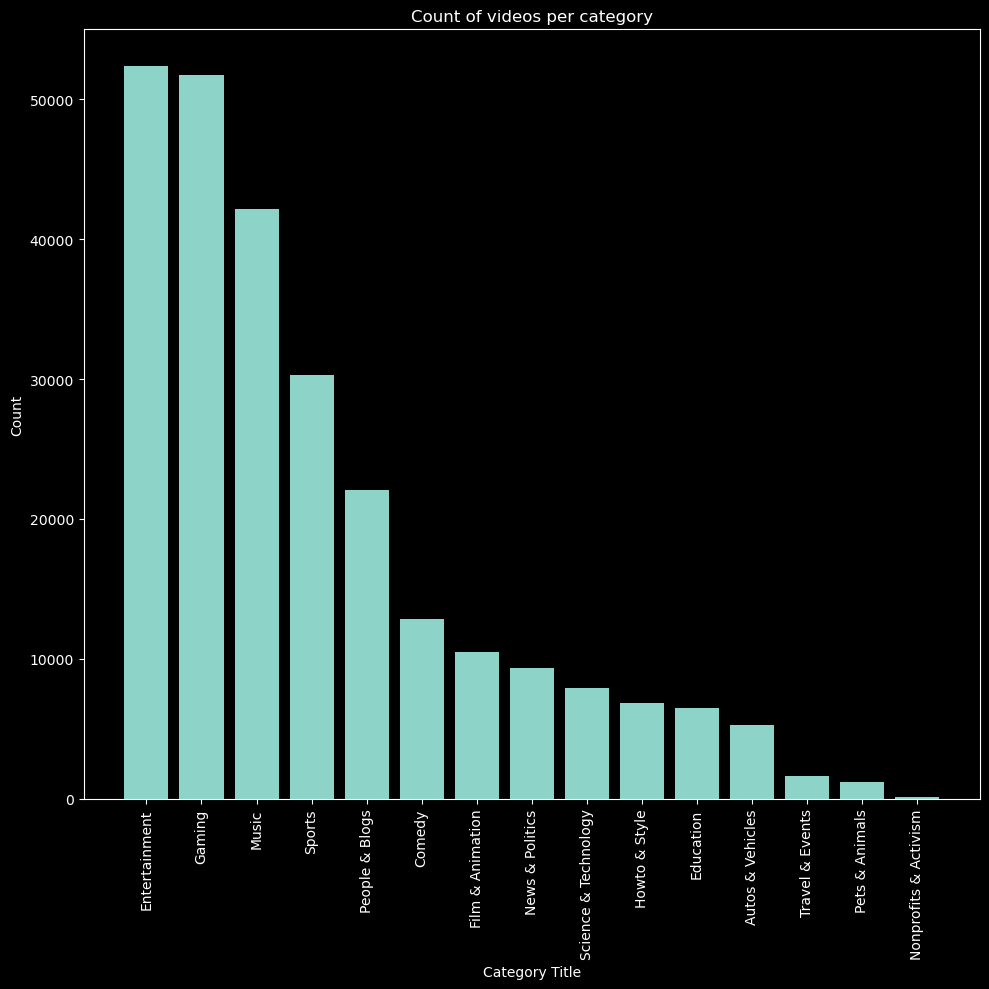

In [60]:

import matplotlib.pyplot as plt

plt.style.use('dark_background')

# xaxis labels should be category titles
category_titles = df.select("categoryId", "categoryTitle").distinct().toPandas()
category_titles = category_titles.set_index("categoryId")

category_counts["categoryTitle"] = category_counts["categoryId"].apply(lambda x: category_titles.loc[x]["categoryTitle"])

plt.figure(figsize=(10, 10))
plt.bar(category_counts["categoryTitle"], category_counts["count"])
plt.xlabel("Category Title")
plt.ylabel("Count")
plt.title("Count of videos per category")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Categories

In [62]:
categories_df = df.groupBy("categoryTitle").sum("view_count").orderBy("sum(view_count)").toPandas()

,categoryTitle,sum(view_count)
0,Nonprofits & Activism,279970874
1,Travel & Events,1526953179
2,Pets & Animals,1619939683
3,Autos & Vehicles,5088025802
4,Howto & Style,8517811953
5,Education,10548338428
6,News & Politics,18448244824
7,Comedy,20497793736
8,Science & Technology,22023719656
9,Film & Animation,28788804964


In [86]:
# Calculate the ratios needed
calculated_df = df.withColumn("like_dislike_ratio", col("likes") / col("dislikes")) \
       .withColumn("like_view_ratio", col("likes") / col("view_count")) \
       .withColumn("comment_view_ratio", col("comment_count") / col("view_count"))

# Group by 'categoryId' and calculate the statistics
result = calculated_df.groupBy("categoryTitle").agg(
    avg("likes").alias("average_likes"),
    avg("dislikes").alias("average_dislikes"),
    avg("comment_count").alias("average_comment_count"),
    avg("view_count").alias("average_view_count"),
    avg("like_dislike_ratio").alias("average_like_dislike_ratio"),
    avg("like_view_ratio").alias("average_like_view_ratio"),
    avg("comment_view_ratio").alias("average_comment_view_ratio"),
    min("likes").alias("minimum_likes"),
    min("dislikes").alias("minimum_dislikes"),
    min("comment_count").alias("minimum_comment_count"),
    min("view_count").alias("minimum_view_count"),
    max("likes").alias("maximum_likes"),
    max("dislikes").alias("maximum_dislikes"),
    max("comment_count").alias("maximum_comment_count"),
    max("view_count").alias("maximum_view_count")
)

#### Base statistics

In [99]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max

# Assuming 'df' is your DataFrame and a Spark session 'spark' is already initialized

# Group by 'categoryId' and calculate base statistics
base_stats = df.groupBy("categoryTitle").agg(
    avg("likes").alias("average_likes"),
    avg("dislikes").alias("average_dislikes"),
    avg("comment_count").alias("average_comment_count"),
    avg("view_count").alias("average_view_count"),
    min("likes").alias("minimum_likes"),
    min("dislikes").alias("minimum_dislikes"),
    min("comment_count").alias("minimum_comment_count"),
    min("view_count").alias("minimum_view_count"),
    max("likes").alias("maximum_likes"),
    max("dislikes").alias("maximum_dislikes"),
    max("comment_count").alias("maximum_comment_count"),
    max("view_count").alias("maximum_view_count")
)

base_stats.show()


+--------------------+------------------+------------------+---------------------+------------------+-------------+----------------+---------------------+------------------+-------------+----------------+---------------------+------------------+
|       categoryTitle|     average_likes|  average_dislikes|average_comment_count|average_view_count|minimum_likes|minimum_dislikes|minimum_comment_count|minimum_view_count|maximum_likes|maximum_dislikes|maximum_comment_count|maximum_view_count|
+--------------------+------------------+------------------+---------------------+------------------+-------------+----------------+---------------------+------------------+-------------+----------------+---------------------+------------------+
|           Education| 89185.89312267659| 625.8500619578687|    5321.507125154894| 1633881.416976456|            0|               0|                    0|                 0|      7940311|          122608|                89133|         149615603|
|              G

#### Ratios

In [98]:
# Calculate the ratios needed
df_with_ratios = df.withColumn("like_dislike_ratio", col("likes") / col("dislikes")) \
                   .withColumn("like_view_ratio", col("likes") / col("view_count")) \
                   .withColumn("comment_view_ratio", col("comment_count") / col("view_count"))

# Group by 'categoryId' and calculate statistics for ratios
ratio_stats = df_with_ratios.groupBy("categoryTitle").agg(
    avg("like_dislike_ratio").alias("average_like_dislike_ratio"),
    avg("like_view_ratio").alias("average_like_view_ratio"),
    avg("comment_view_ratio").alias("average_comment_view_ratio"),
    min("like_dislike_ratio").alias("minimum_like_dislike_ratio"),
    min("like_view_ratio").alias("minimum_like_view_ratio"),
    min("comment_view_ratio").alias("minimum_comment_view_ratio"),
    max("like_dislike_ratio").alias("maximum_like_dislike_ratio"),
    max("like_view_ratio").alias("maximum_like_view_ratio"),
    max("comment_view_ratio").alias("maximum_comment_view_ratio")
)

ratio_stats.show()


+--------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------+--------------------------+
|       categoryTitle|average_like_dislike_ratio|average_like_view_ratio|average_comment_view_ratio|minimum_like_dislike_ratio|minimum_like_view_ratio|minimum_comment_view_ratio|maximum_like_dislike_ratio|maximum_like_view_ratio|maximum_comment_view_ratio|
+--------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------+--------------------------+
|           Education|          107.153981095735|    0.05904387126508623|      0.004566668954540359|       0.11040878246117708|                    0.0|                       0.0|         849.9787234042553|     0.2366573683898154|

In [100]:
# graph the results on bar chart
import plotly.graph_objects as go

fig = go.Figure()

# Create a list of the columns to plot
columns = [
    "average_likes",
    "average_dislikes",
    "average_comment_count",
    "average_view_count",
    "average_like_dislike_ratio",
    "average_like_view_ratio",
    "average_comment_view_ratio"
]

# Create the bar chart
for column in columns:
    fig.add_trace(go.Bar(
        x=result.select("categoryTitle").toPandas()["categoryTitle"],
        y=result.select(column).toPandas()[column],
        name=column
    ))

# Update the layout
fig.update_layout(
    barmode='group',
    title="Average metrics per category",
    xaxis_title="Category",
    yaxis_title="Average value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

# change height to 1200px
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

fig.show()

## Distribution

In [ ]:
# For numerical columns
numerical_cols = ['view_count', 'likes', 'dislikes', 'comment_count']
df.select(numerical_cols).describe().show()

+-------+-----------------+------------------+-----------------+------------------+
|summary|       view_count|             likes|         dislikes|     comment_count|
+-------+-----------------+------------------+-----------------+------------------+
|  count|           260787|            260787|           260787|            260787|
|   mean|2692467.785077477| 131219.9604351444|1169.073017443354|10208.705188525502|
| stddev|8729430.316258574|452251.69212524034|8167.300333295418| 73606.70150388633|
|    min|                0|                 0|                0|                 0|
|    max|        277791741|          16021534|           879354|           6738537|
+-------+-----------------+------------------+-----------------+------------------+



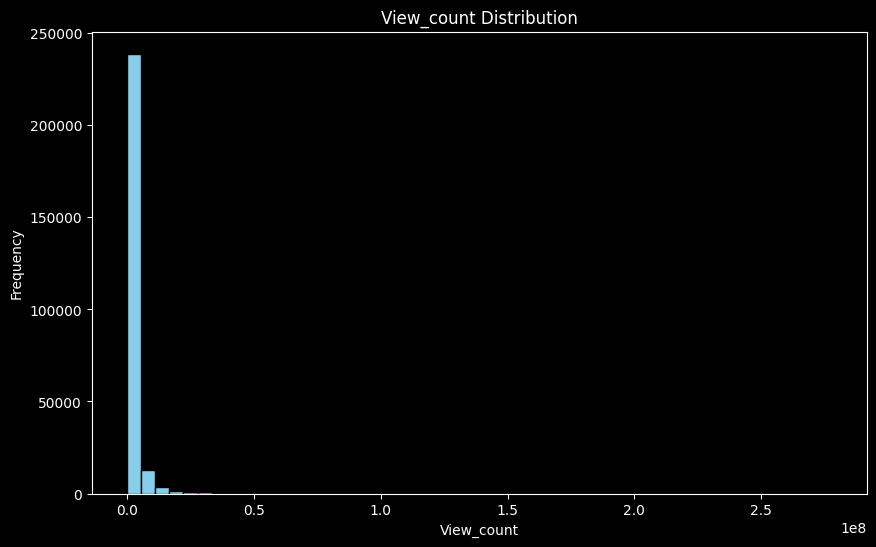

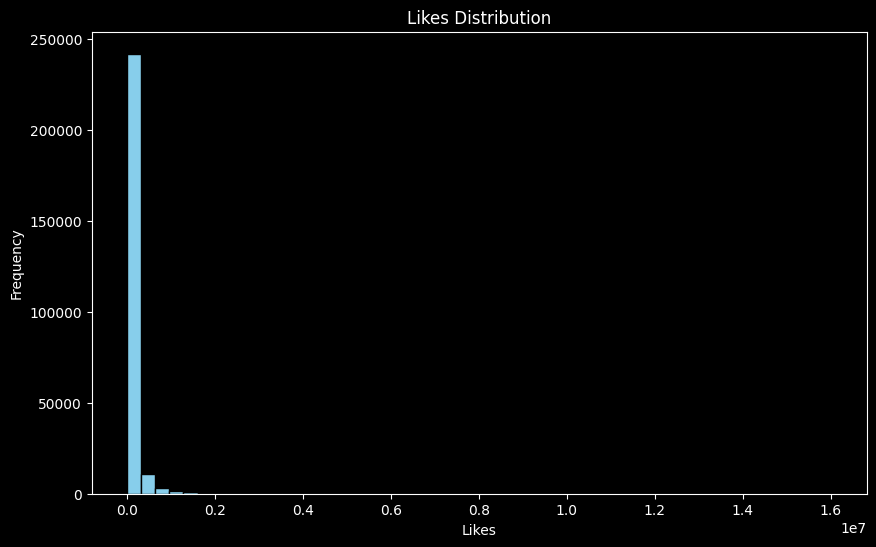

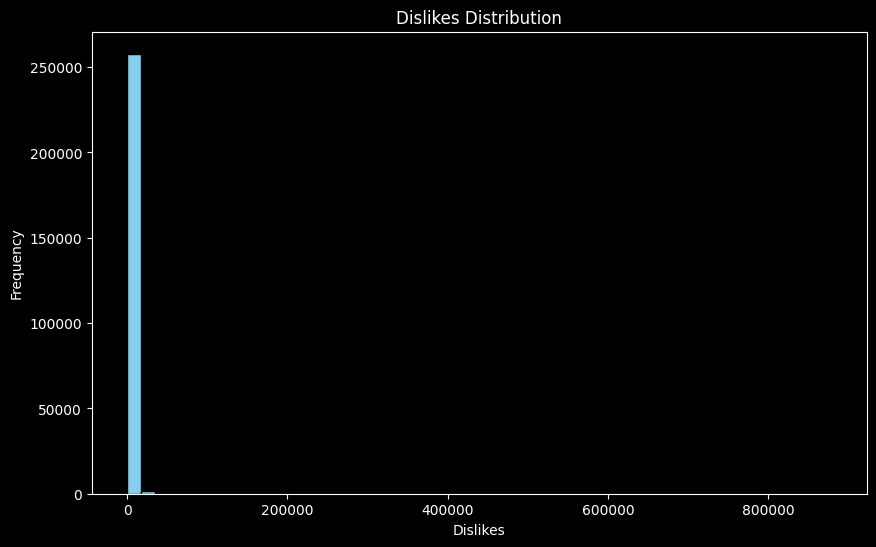

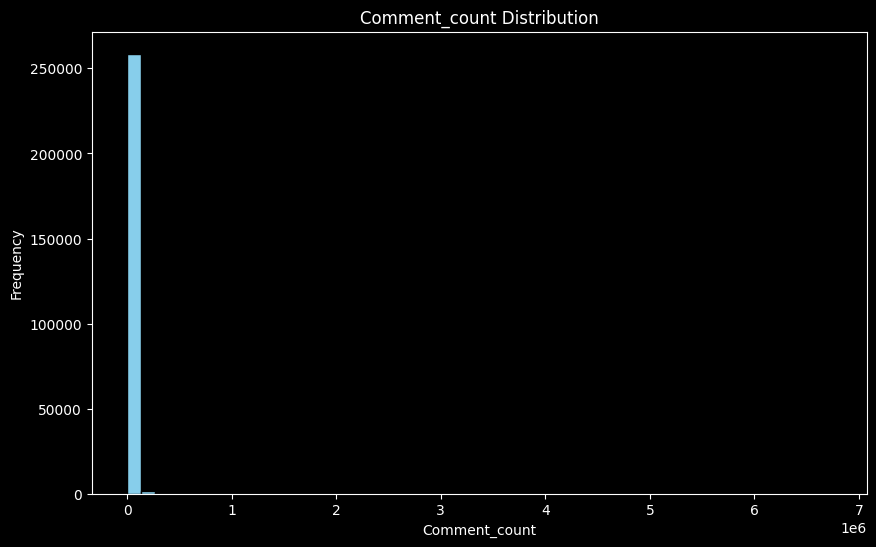

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(df, columns, bins=50):
    """
    Plots histograms for the specified continuous variables in a Spark DataFrame.
    
    Parameters:
    - df: Spark DataFrame containing the data.
    - columns: List of column names (strings) for which to plot histograms.
    - bins: Number of bins to use in the histograms (default is 50).
    """
    for column in columns:
        # Aggregate data in Spark
        data = df.select(column).rdd.flatMap(lambda x: x).collect()
        
        # Plot using Matplotlib in Python
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'{column.capitalize()} Distribution')
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.show()

# Example usage with your DataFrame and continuous variables
continuous_vars = ['view_count', 'likes', 'dislikes', 'comment_count']
plot_histograms(df, continuous_vars)


above plots show that all continuous variables are heaviliy right-tail skewed, therefore log transformation might be beneficial

## Transformations

In [ ]:
from pyspark.sql.functions import log1p

# Apply log transformation to each specified column
for column in continuous_vars:
    # Add a new column with the log transformation applied
    df = df.withColumn(column + '_log', log1p(col(column)))

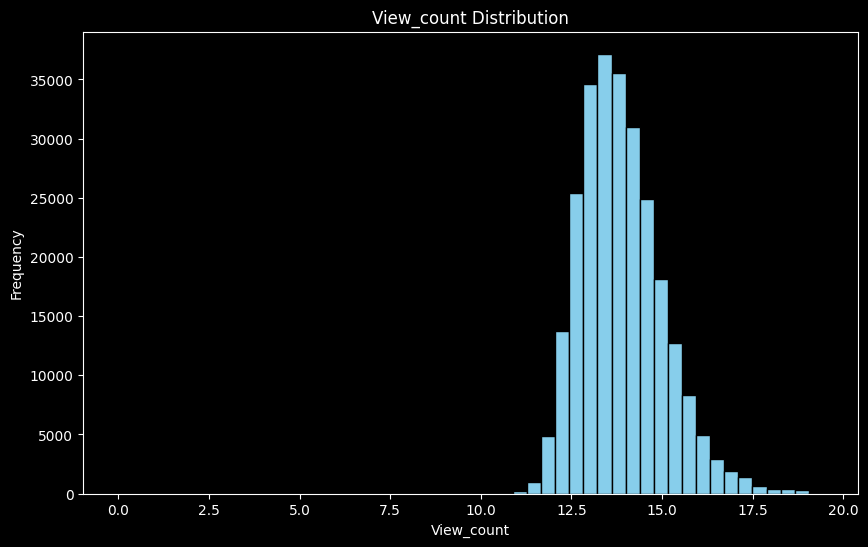

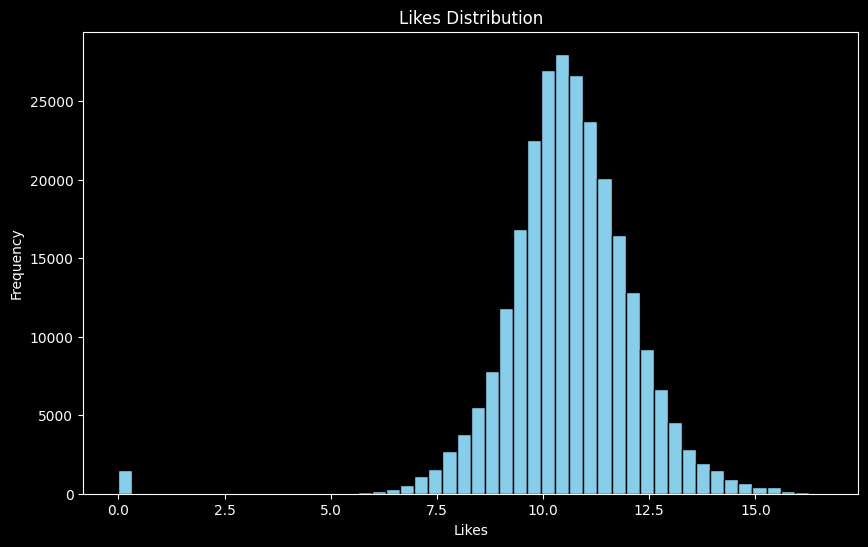

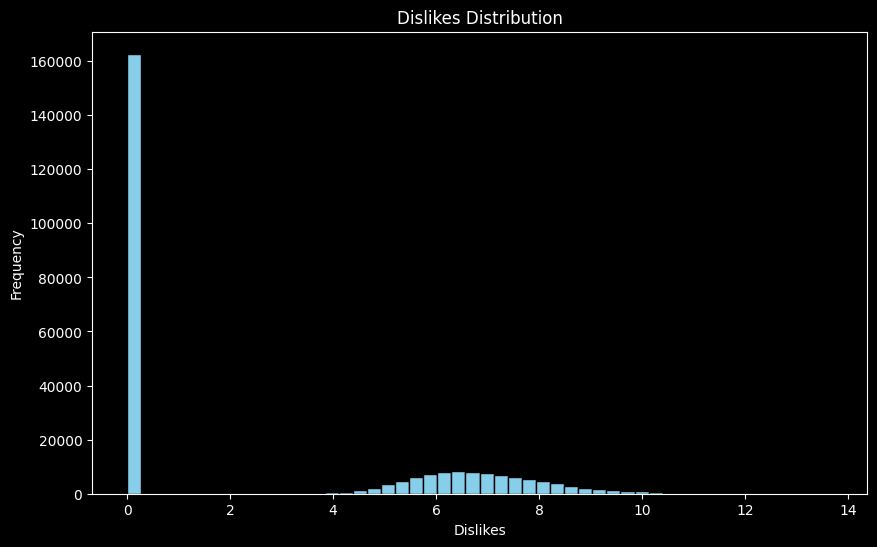

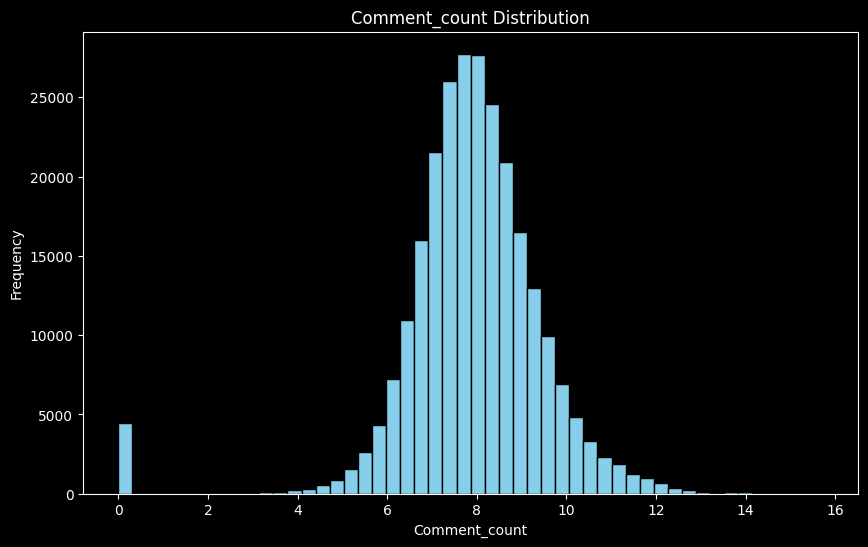

In [ ]:
# Replot histograms for the log-transformed variables
plot_histograms(df, continuous_vars)


### Categorical Variables

#### Aggregate Category Popularity

In [ ]:
# For a categorical column like 
category_popularity = df.groupBy("categoryTitle").count().orderBy("count", ascending=False).toPandas()

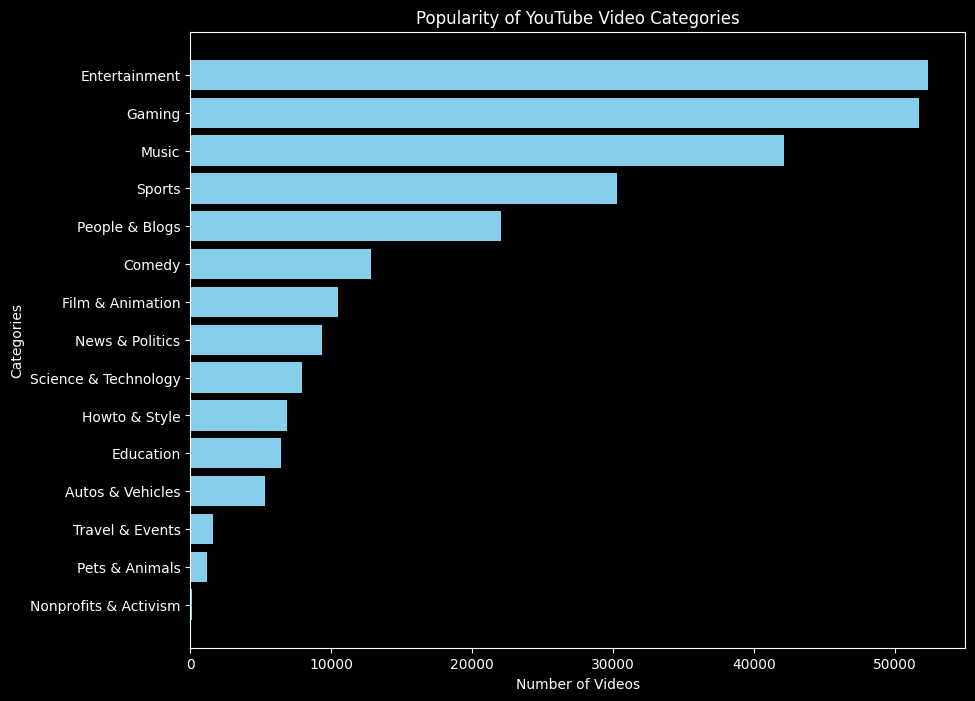

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(category_popularity['categoryTitle'], category_popularity['count'], color='skyblue')
plt.xlabel('Number of Videos')
plt.ylabel('Categories')
plt.title('Popularity of YouTube Video Categories')
plt.gca().invert_yaxis()  # Invert y-axis to have the most popular category at the top

# use skin 
plt.style.use('dark_background')


plt.show()


#### tag freq

In [ ]:
from pyspark.sql.functions import explode, split

# Split the tags string into an array of tags, then explode the array into individual rows
tags_df = df.withColumn("tag", explode(split("tags", "\|")))

# Group by the individual tags and count occurrences
tag_counts = tags_df.groupBy("tag").count().orderBy("count", ascending=False).limit(20).toPandas()

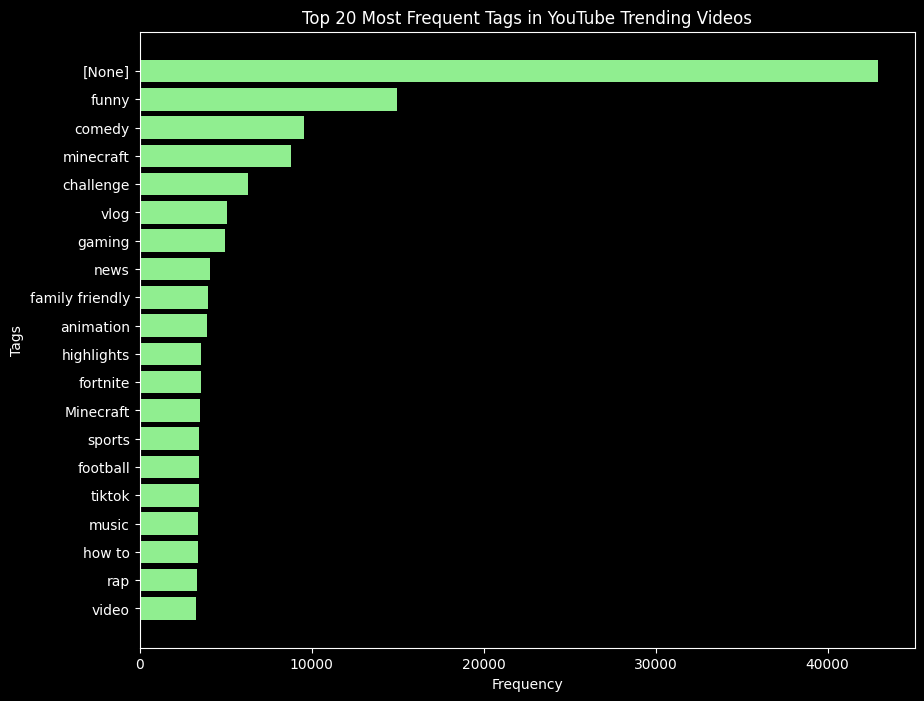

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(tag_counts['tag'], tag_counts['count'], color='lightgreen')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Frequent Tags in YouTube Trending Videos')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent tag at the top
plt.show()


## save transformed data

In [ ]:
# save parquet file
df.write.parquet("data/processed/tranformed_US_youtube_trending_data.parquet", mode="overwrite")

In [ ]:
# df_with_categories to pandas
# df_with_categories = df_with_categories.toPandas()
df.head(5)

df.printSchema()

root
 |-- categoryId: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: double (nullable = true)
 |-- likes: double (nullable = true)
 |-- dislikes: double (nullable = true)
 |-- comment_count: double (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- categoryTitle: string (nullable = true)

